In [1]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER='./'
POKEMON_FILE=join(DATA_FOLDER,'pokemon.csv')
COMBATS_FILE=join(DATA_FOLDER,'combats.csv')

df_pokemons=pd.read_csv(POKEMON_FILE,index_col=0)
df_combats=pd.read_csv(COMBATS_FILE)

In [9]:
df_pokemons.head()

,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
pid,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [10]:
df_combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


## Question 1: Exploring the data - 30 points
In this part, you will explore the data to address the curiosities of the demanding Professor Oak.

1. (6 points) Explore the data and report some descriptive statistics (e.g., use df.describe(), report the number of classes, summarize the attack and defense distributions, etc.). This will be useful later in your analysis.
2. (4 points) Compare the probability distribution of the “regular attack” feature with that of the “regular defense” feature. In particular,
   1. visualize the relation between these two variables using an appropriate plot;
   2. list the names of the 3 Pokémon with highest attack-over-defense ratio;
   3. list the names of the 3 Pokémon with lowest attack-over-defense ratio;
   4. list the names of the 10 Pokémon with the largest number of victories.
3. (10 points) Professor Oak suspects that Pokémon in the _grass_ class have a stronger regular attack than those in the _rock_ class. Check if he is right and convince him of your conclusion with statistical arguments.
   Note: If there are Pokémon that are in both classes, discard them.
   Note: You may assume that the distribution of the regular attack feature is normal for all Pokémon classes.
4. (10 points) Professor Oak reveals to you that he has built a backdoor into every Pokedex in the world and that he is secretly dumping the memory of all devices to his servers. He expects to have the records of 1 billion combats soon, and one machine won’t be enough to handle all this data, so he wants you to use Spark. Your task: Solve problem 2iv above (“list the names of the 10 Pokémon with the largest number of victories”) with a Spark implementation in Python. The output should be a Python list with 10 names sorted in descending order of number of victories.
   Note: You don’t need to run the Spark code -- just list it! You should assume that you have two DataFrames (already loaded) called `pokemon` and `combats`, with the same schema as the small CSV files you’ve been working with above.

In [12]:
df_pokemons.sample(5)

,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
pid,,,,,,,,,,
278,Combusken,Fire,Fighting,60,85,60,85,60,55,False
265,Suicune,Water,NaN,100,75,115,90,115,85,True
714,Keldeo Ordinary Forme,Water,Fighting,91,72,90,129,90,108,False
758,Malamar,Dark,Psychic,86,92,88,68,75,73,False
466,Buizel,Water,NaN,55,65,35,60,30,85,False


Let's take a look at dependence between Pokemon classes

In [56]:
def get_crosstab(df,column_1,column_2):
    #Build a crosstab
    df2=pd.crosstab(df[column_1],df[column_2])
    
    #Columns indexing so the highest numbers are in the left
    cols=df2.max(axis=0).sort_values(ascending=False).index
    
    #Rows indexing so the highest numbers are in the bottom
    rows=df2.max(axis=1).sort_values(ascending=True).index
    
    df2=df2[cols].reindex(index=rows)
    
    sns.heatmap(df2,annot=True)
    plt.title('Cross occurence of two classes')
    
    #Names presented in both classes 
    common_labels=np.intersect1d(df2.index,df2.columns)
    
    #Names presented in either of 2 classes
    add_columns=np.setdiff1d(df2.columns,df2.index)
    add_rows=np.setdiff1d(df2.index,df2.columns)
    
    print('Total number of classes is %d' % (len(common_labels)+len(add_columns)+len(add_rows)))
    if len(add_rows)>0:
        print('%d belongs only to Class 1' % len(add_rows))
    if len(add_columns)>0:
        print('%d belongs only to Class 2' % len(add_columns))
    
    return df2

## Cross tab of classes

Total number of classes is 18


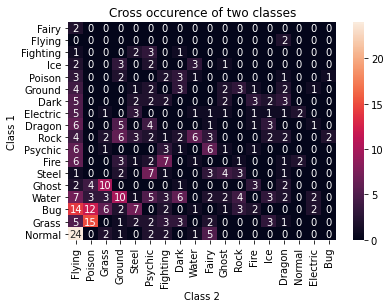

In [57]:
classes_df=get_crosstab(df_pokemons,'Class 1','Class 2')

So we can clearly see some relations between classes

# Descriptive statistics of the pokemons

In [422]:
def describe_df(df):
    sns.boxplot(data=df)
    plt.title('Dataset desciption')
    plt.ylabel('Numerical values')
    plt.xlabel('Features')
    plt.show()
    return df.describe()

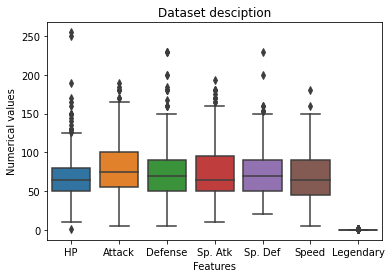

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [61]:
describe_df(df_pokemons)

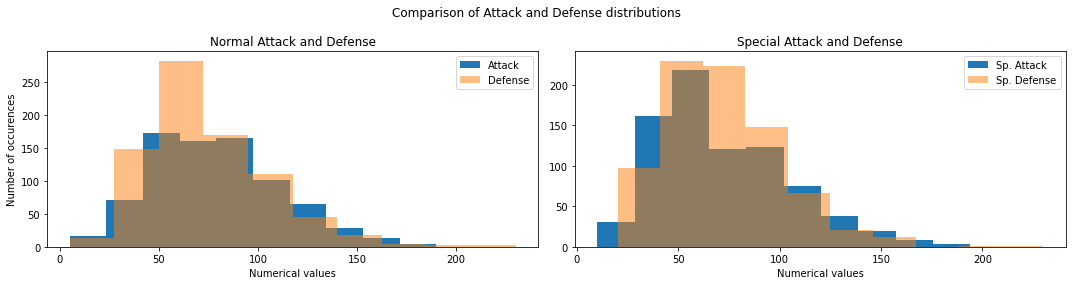

In [87]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

fig.suptitle('Comparison of Attack and Defense distributions')

ax[0].hist(df_pokemons.Attack,alpha=1,label='Attack')
ax[0].hist(df_pokemons.Defense,alpha=0.5,label='Defense')
ax[0].set_xlabel('Numerical values')
ax[0].set_ylabel('Number of occurences')
ax[0].legend()
ax[0].set_title('Normal Attack and Defense')

ax[1].hist(df_pokemons['Sp. Atk'],alpha=1,label='Sp. Attack')
ax[1].hist(df_pokemons['Sp. Def'],alpha=0.5,label='Sp. Defense')
ax[1].set_xlabel('Numerical values')
ax[1].legend()
ax[1].set_title('Special Attack and Defense')

plt.tight_layout()
plt.show()

# Relation between Attack and Defense

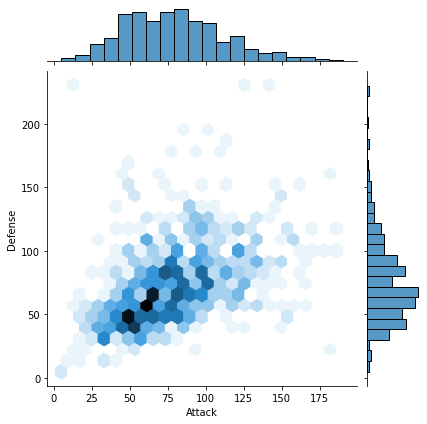

In [90]:
sns.jointplot(data=df_pokemons,x='Attack',y='Defense',kind='hex')

In [123]:
df_pokemons['Attack_over_Defense']=df_pokemons.Attack/df_pokemons.Defense
Attack_to_defense=pd.DataFrame(columns=['Highest A/D','Lowest A/D'])
Attack_to_defense['Highest A/D']=df_pokemons.sort_values('Attack_over_Defense',ascending=False).head(3).Name.values
Attack_to_defense['Lowest A/D']=df_pokemons.sort_values('Attack_over_Defense',ascending=True).head(3).Name.values
print('Attack to Defense ratio')
Attack_to_defense

Attack to Defense ratio


,Highest A/D,Lowest A/D
0,DeoxysAttack Forme,Shuckle
1,Carvanha,Magikarp
2,Mega Beedrill,Bronzor


In [122]:
print('Largest number of victories')
df_pokemons['Number_of_victories']=df_combats['Winner'].value_counts()
df_pokemons.sort_values('Number_of_victories',ascending=False)[['Name','Number_of_victories']].head(10)

Largest number of victories


,Name,Number_of_victories
pid,,
163,Mewtwo,152.0
154,Aerodactyl,136.0
438,Infernape,136.0
428,Jirachi,134.0
432,Deoxys Speed Forme,133.0
314,Slaking,133.0
214,Murkrow,130.0
394,Mega Absol,130.0
249,Mega Houndoom,128.0


# Check whether the grass pokemons have higher attack then the rock ones

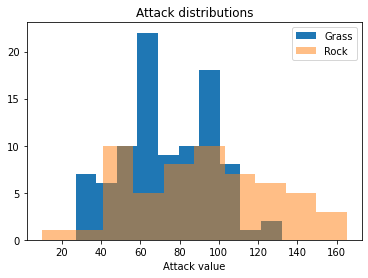

In [132]:
grass_class=((df_pokemons['Class 1']=='Grass') | (df_pokemons['Class 2']=='Grass'))
rock_class=((df_pokemons['Class 1']=='Rock') | (df_pokemons['Class 2']=='Rock'))

only_grass=df_pokemons[grass_class & np.logical_not(rock_class)]
only_rock=df_pokemons[rock_class & np.logical_not(grass_class)]

plt.hist(only_grass.Attack,label='Grass',alpha=1)
plt.hist(only_rock.Attack,label='Rock',alpha=0.5)
plt.legend()
plt.title('Attack distributions')
plt.xlabel('Attack value')
plt.show()

In [142]:
print('Grass attack Mean=%d and Variance=%d' % (only_grass.Attack.mean(),only_grass.Attack.std()))
print('Rock attack Mean=%d and Variance=%d'% (only_rock.Attack.mean(),only_rock.Attack.std()))

Grass attack Mean=73 and Variance=24
Rock attack Mean=91 and Variance=34


Given the assumption that the distribution of the regular attack feature is normal for all Pokémon classes we can use statistical t-test to evaluate whether mean values of studied features are significantly different. However, we need to account for different variances, therefore choose Welch’s t-test

In [143]:
from scipy.stats import ttest_ind
ttest_ind(only_rock.Attack,only_grass.Attack,equal_var=False)

Ttest_indResult(statistic=3.4169379582521513, pvalue=0.0009640546913545304)

p_value<0.05, therefore the difference between classes mean values is significant. Moreover, professor is not right, because the Rock pokemons in average have higher attack than the Grass ones

# Scaling up

In [145]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [156]:
Scaled_pokemons=spark.read.load(POKEMON_FILE,format='csv',header='true')
Scaled_combats=spark.read.load(COMBATS_FILE,format='csv',header='true')

Scaled_pokemons.printSchema()
Scaled_combats.printSchema()

root
 |-- pid: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Class 1: string (nullable = true)
 |-- Class 2: string (nullable = true)
 |-- HP: string (nullable = true)
 |-- Attack: string (nullable = true)
 |-- Defense: string (nullable = true)
 |-- Sp. Atk: string (nullable = true)
 |-- Sp. Def: string (nullable = true)
 |-- Speed: string (nullable = true)
 |-- Legendary: string (nullable = true)

root
 |-- First_pokemon: string (nullable = true)
 |-- Second_pokemon: string (nullable = true)
 |-- Winner: string (nullable = true)



In [207]:
#Aggregate number of victories, sort by number and take top 10
Victory_numbers=Scaled_combats.groupby('Winner').agg(count('*')).sort(desc('count(1)')).limit(10)

In [208]:
#Join to datasets to get the names
Pokemons_names_victories=Victory_numbers.join(Scaled_pokemons,Scaled_pokemons.pid==Victory_numbers.Winner)

In [209]:
Pokemons_names_victories.show()

+------+--------+---+------------------+-------+--------+---+------+-------+-------+-------+-----+---------+
|Winner|count(1)|pid|              Name|Class 1| Class 2| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Legendary|
+------+--------+---+------------------+-------+--------+---+------+-------+-------+-------+-----+---------+
|   154|     136|154|        Aerodactyl|   Rock|  Flying| 80|   105|     65|     60|     75|  130|    FALSE|
|   155|     127|155|   Mega Aerodactyl|   Rock|  Flying| 80|   135|     85|     70|     95|  150|    FALSE|
|   163|     152|163|            Mewtwo|Psychic|    null|106|   110|     90|    154|     90|  130|     TRUE|
|   214|     130|214|           Murkrow|   Dark|  Flying| 60|    85|     42|     85|     42|   91|    FALSE|
|   249|     128|249|     Mega Houndoom|   Dark|    Fire| 75|    90|     90|    140|     90|  115|    FALSE|
|   314|     133|314|           Slaking| Normal|    null|150|   160|    100|     95|     65|  100|    FALSE|
|   394|     130|39

In [213]:
Names=Pokemons_names_victories.sort(desc('count(1)')).select('Name').collect()

In [220]:
Names_list=[name.Name for name in Names]
print(Names_list)

['Mewtwo', 'Aerodactyl', 'Infernape', 'Jirachi', 'Slaking', 'Deoxys Speed Forme', 'Murkrow', 'Mega Absol', 'Mega Houndoom', 'Mega Aerodactyl']


In [221]:
df_pokemons.sort_values('Number_of_victories',ascending=False)[['Name','Number_of_victories']].head(10)

,Name,Number_of_victories
pid,,
163,Mewtwo,152.0
154,Aerodactyl,136.0
438,Infernape,136.0
428,Jirachi,134.0
432,Deoxys Speed Forme,133.0
314,Slaking,133.0
214,Murkrow,130.0
394,Mega Absol,130.0
249,Mega Houndoom,128.0


Correct answer

## Question 2: Prediction - 40 points
Now that you know what your data looks like, you are ready to implement the prediction model for the Pokedex 2.0. The model should take as input the features of two Pokémon and generate a binary value to predict who will win.

1. (3 points) Generate the feature vectors and the labels to train your model.
2. (5 points) How does your model handle categorical features and Pokémon with multiple classes?
3. (10 points) Train a random forest to predict the winner of a match based on the available features. To do so, split the full dataset randomly into a training set (90%) and a testing set (10%), and try different values of the number of estimators (`n_estimators`, try values 10, 25, 50, 100) and the maximum tree depth (`max_depth`, try values 2, 4, 10). Do this manually, without using any scikit-learn helpers.
4. (5 points) Summarize and describe the results you obtain when training on 90% and testing on 10% of the data. What is the best combination of the two hyperparameters (number of estimators and maximum tree depth)?
5. (5 points) Could the above training/testing setup potentially lead to wrong conclusions regarding the best hyperparameter setting? If so, describe why, and how you would address the problem. (Hint: think about how you’re making use of the data during training and testing).
6. (7 points) Implement your solution to the problem you’ve identified in the previous subquestion (5), and show and describe your results.
7. (5 points) Finally, Professor Oak wants to know what the most predictive features are. Plot feature importance as a bar plot representing the 10 most predictive variables.

In [223]:
df_pokemons.head()

,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack_over_Defense,Number_of_victories
pid,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,1.000000,37.0
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,0.984127,46.0
3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,0.987952,89.0
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,0.813008,70.0
5,Charmander,Fire,NaN,39,52,43,60,50,65,False,1.209302,55.0


In [224]:
df_combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [234]:
def count_unique_index(df, by):                                                                                                                                                 
    return df.groupby(by).size().reset_index().rename(columns={0:'count'}) 

In [238]:
df_pokemons.columns

Index(['Name', 'Class 1', 'Class 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Legendary', 'Attack_over_Defense',
       'Number_of_victories'],
      dtype='object')

In [236]:
len(count_unique_index(df_combats,['First_pokemon','Second_pokemon']))

48048

In [237]:
len(df_combats)

50000

Not unique

0 - first pokemon won, 1 - second pokemon won

In [275]:
from tqdm import tqdm

In [284]:
df_pokemons=pd.read_csv(POKEMON_FILE,index_col=0)
df_pokemons=pd.get_dummies(df_pokemons.drop('Name',axis=1))
df_pokemons.Legendary=df_pokemons.Legendary.astype(int)
df_pokemons.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Class 1_Bug,Class 1_Dark,Class 1_Dragon,...,Class 2_Ghost,Class 2_Grass,Class 2_Ground,Class 2_Ice,Class 2_Normal,Class 2_Poison,Class 2_Psychic,Class 2_Rock,Class 2_Steel,Class 2_Water
pid,,,,,,,,,,,,,,,,,,,,,
1,45,49,49,65,65,45,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,60,62,63,80,80,60,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,80,82,83,100,100,80,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,80,100,123,122,120,80,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,39,52,43,60,50,65,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [285]:
df_pokemons.columns

Index(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary',
       'Class 1_Bug', 'Class 1_Dark', 'Class 1_Dragon', 'Class 1_Electric',
       'Class 1_Fairy', 'Class 1_Fighting', 'Class 1_Fire', 'Class 1_Flying',
       'Class 1_Ghost', 'Class 1_Grass', 'Class 1_Ground', 'Class 1_Ice',
       'Class 1_Normal', 'Class 1_Poison', 'Class 1_Psychic', 'Class 1_Rock',
       'Class 1_Steel', 'Class 1_Water', 'Class 2_Bug', 'Class 2_Dark',
       'Class 2_Dragon', 'Class 2_Electric', 'Class 2_Fairy',
       'Class 2_Fighting', 'Class 2_Fire', 'Class 2_Flying', 'Class 2_Ghost',
       'Class 2_Grass', 'Class 2_Ground', 'Class 2_Ice', 'Class 2_Normal',
       'Class 2_Poison', 'Class 2_Psychic', 'Class 2_Rock', 'Class 2_Steel',
       'Class 2_Water'],
      dtype='object')

In [287]:
feature_columns=df_pokemons.columns

feature_cols_1=[column+'_1' for column in feature_columns]
feature_cols_2=[column+'_2' for column in feature_columns]

df_win_prediction=pd.DataFrame(index=np.arange(len(df_combats)),columns=['result']+feature_cols_1+feature_cols_2)

#Build a dataframe with features and results
for index,combat in tqdm(df_combats.iterrows()):
    
    first_poc_index=combat.First_pokemon
    second_poc_index=combat.Second_pokemon
    
    
    result=int(combat.Winner==second_poc_index)
    
    #print(first_poc_index,second_poc_index)
    
    features_1=df_pokemons.loc[first_poc_index][feature_columns].values
    features_2=df_pokemons.loc[second_poc_index][feature_columns].values
    
    features=np.append(features_1,features_2)
    complete_row=np.append([result],features)
    
    df_win_prediction.iloc[index]=complete_row

50000it [01:29, 559.19it/s]


In [288]:
df_win_prediction.head()

,result,HP_1,Attack_1,Defense_1,Sp. Atk_1,Sp. Def_1,Speed_1,Legendary_1,Class 1_Bug_1,Class 1_Dark_1,...,Class 2_Ghost_2,Class 2_Grass_2,Class 2_Ground_2,Class 2_Ice_2,Class 2_Normal_2,Class 2_Poison_2,Class 2_Psychic_2,Class 2_Rock_2,Class 2_Steel_2,Class 2_Water_2
0,1,50,64,50,45,50,41,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,91,90,72,90,129,108,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,55,40,85,80,105,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,40,40,40,70,40,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,70,60,125,115,70,55,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [313]:
#All the dataset consists of numbers now
(df_win_prediction.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())).all()

True

In [314]:
def train_test_split(df,p=0.8):
    shuffled_df=df.iloc[np.random.permutation(len(df))]
    
    Train=shuffled_df.iloc[:int(p*len(df))]
    Test=shuffled_df.iloc[int(p*len(df)):]
    
    return Train,Test

In [320]:
Train,Test=train_test_split(df_win_prediction.astype(int),p=0.9)

X_train=Train.iloc[:,1:]
y_train=Train.iloc[:,0]

X_test=Test.iloc[:,1:]
y_test=Test.iloc[:,0]

In [342]:
from sklearn.ensemble import RandomForestClassifier

n_estimators=[10,25,50,100]
max_depth=[2,4,10]

accuracies=np.zeros((4,3))

for i,nt in tqdm(enumerate(n_estimators)):
    for j,depth in enumerate(max_depth):
        clf = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=nt)
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_test)
        accuracy = (y_pred==y_test).sum()/len(y_pred)
        accuracies[i,j]=accuracy

4it [00:16,  4.05s/it]


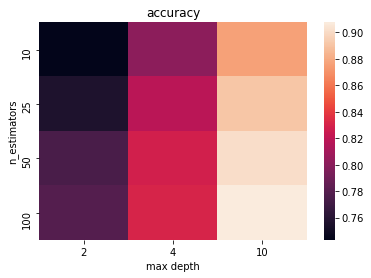

In [356]:
ax=sns.heatmap(accuracies,yticklabels=n_estimators,xticklabels=max_depth)
ax.set_title('accuracy')
plt.xlabel('max depth')
plt.ylabel('n_estimators')
plt.show()

Increase of both depth and number of estimators increases accuracy. The highest one refers to n_estimators=100, max_depth=10

Splitting dataset can bring uncertanties in our estimations, since these sets are fixed and we may miss some data. Instead we can train the model on whole dataset and estimate accuracy with k-fold cross validation

# Make use of cross val instead of usual train/test split

4it [02:56, 44.03s/it]


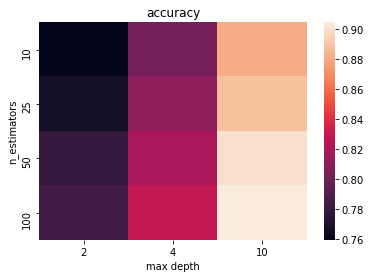

In [363]:
from sklearn.model_selection import cross_val_score

X=df_win_prediction.astype(int).iloc[:,1:]
y=df_win_prediction.astype(int).iloc[:,0]

accuracies=np.zeros((4,3))

for i,nt in tqdm(enumerate(n_estimators)):
    for j,depth in enumerate(max_depth):
        clf = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=nt)
        clf.fit(X, y)
        accuracies[i,j]=cross_val_score(clf, X, y, cv=10, scoring="accuracy").mean()

ax=sns.heatmap(accuracies,yticklabels=n_estimators,xticklabels=max_depth)
ax.set_title('accuracy')
plt.xlabel('max depth')
plt.ylabel('n_estimators')
plt.show()

So the lowest accuracy got higher, whereas the highest didn't change much. Guess it means that we extracted more general data out of the dataset, without overfitting it due to cross_validation.

In [365]:
clf = RandomForestClassifier(max_depth=max_depth[-1], random_state=0, n_estimators=n_estimators[-1])
clf.fit(X, y)

RandomForestClassifier(max_depth=10, random_state=0)

In [375]:
top_features

Speed_1      0.304674
Speed_2      0.282537
Attack_1     0.052410
Attack_2     0.048719
Sp. Atk_1    0.045892
Sp. Atk_2    0.038194
HP_1         0.024491
HP_2         0.023690
Sp. Def_1    0.022060
Sp. Def_2    0.021918
dtype: float64

Text(0.5, 0, 'Feature importance')

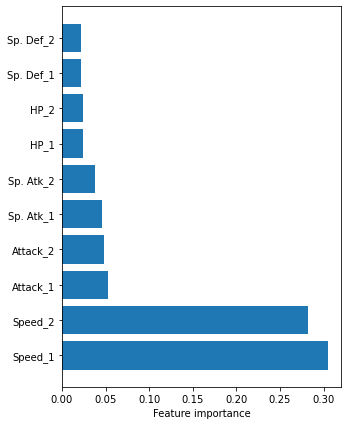

In [379]:
feature_importance=pd.Series(index=X.columns,data=clf.feature_importances_)
top_features=feature_importance.reindex(feature_importance.abs().sort_values(ascending=False).index).iloc[:10]
plt.subplots(figsize=(5,7))
plt.barh(top_features.index, top_features.values)
plt.xlabel('Feature importance')

## Question 3: Ranking - 30 points
Something the new Pokedex is missing is a smart way of ranking the Pokémon. As the dataset Professor Oak gave you contains the outcome of a large number of battles, the idea is to use this data to come up with a way of sorting the Pokémon from strongest to weakest.
1. (5 points) Compute the winning ratio (number of wins divided by number of battles) for all Pokémon. Show the 10 Pokémon with the highest ratio and describe what they have in common with respect to their features. Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.

Pokémon tournaments can be represented as a so-called _dominance graph_. The dominance graph is a directed graph in which each Pokémon is represented by one vertex, and directed edges point from stronger to weaker Pokémons: in particular, if Pokémon _i_ has won a strictly larger number of times against Pokémon _j_ than _j_ has won against _i_ (that is, if _i_ dominates _j_), there is a directed edge pointing from node _i_ to node _j_. The dominance graph can be represented as an adjacency matrix _G_ where entry _G_<sub>_ij_</sub> is 1 if there is an edge pointing from _i_ to _j_, and 0 otherwise.

2. (10 points) A simple method for identifying the strongest Pokémon using this graph is to compute the matrix _A_ = _G_ + _G_<sup>2</sup>. Consider a given row of _A_; summing up all elements of that row results in a dominance score for the respective Pokémon. Explain what this score represents and why it may be interpreted as capturing the dominance of a Pokémon.
3. (7 points) Compute _A_ and extract the 10 Pokémon with the highest dominance score.
4. (3 points) Compare the ranking by dominance scores with the ranking by winning ratio (cf. subquestion 1 above). What do you observe? How do you explain the differences (if any)?
5. (5 points) Professor Oak is really keen on featuring a solid ranking mechanism in the new Pokedex, so you need to make a decision: Which scoring method is better, that based on winning ratio or that based on dominance scores? Support your opinion with explanations and examples.

In [411]:
df_pokemons=pd.read_csv(POKEMON_FILE,index_col=0)

In [412]:
df_combats['binary_winner']=(df_combats.Winner==df_combats.First_pokemon).astype(int)

#1 means victory of first pokemon, hence sum is number of victories
first_combats=df_combats[['First_pokemon','binary_winner']].groupby('First_pokemon').agg(['count','sum'])

#for the second one number of victories is count-sum
second_combats=df_combats[['Second_pokemon','binary_winner']].groupby('Second_pokemon').agg(['count','sum'])
second_combats['binary_winner','sum']=second_combats['binary_winner','count']-\
    second_combats['binary_winner','sum']
pokemon_battle_statistics=pd.concat([first_combats,second_combats]).groupby(level=0).sum()
pokemon_battle_statistics.head()

binary_winner    
          count sum
1           133  37
2           121  46
3           132  89
4           125  70
5           112  55

In [414]:
df_pokemons['WR']=pokemon_battle_statistics['binary_winner','sum']/pokemon_battle_statistics['binary_winner','count']

In [436]:
df_pokemons.Legendary=df_pokemons.Legendary.astype(int)
top_WR=df_pokemons.sort_values('WR',ascending=False).iloc[:10]

In [437]:
top_WR

,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,WR
pid,,,,,,,,,,,
155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,0,0.984496
513,Weavile,Dark,Ice,70,120,65,45,85,125,0,0.974790
704,Tornadus Therian Forme,Flying,NaN,79,100,80,110,90,121,1,0.968000
20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,0,0.966387
154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,0,0.964539
477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,0,0.961240
727,Greninja,Water,Dark,72,95,67,103,71,122,0,0.960630
717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,0,0.959350
165,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,0.952000


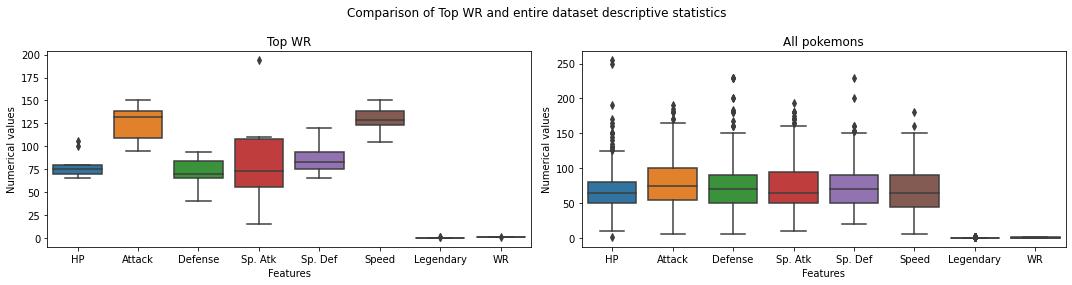

In [453]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

fig.suptitle('Comparison of Top WR and entire dataset descriptive statistics')

sns.boxplot(ax=ax[0],data=top_WR)
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Numerical values')
ax[0].set_title('Top WR')

sns.boxplot(ax=ax[1],data=df_pokemons)
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Numerical values')
ax[1].set_title('All pokemons')

plt.tight_layout()
plt.show()

Let's inspect how mean values of top pokemons differ from the other ones

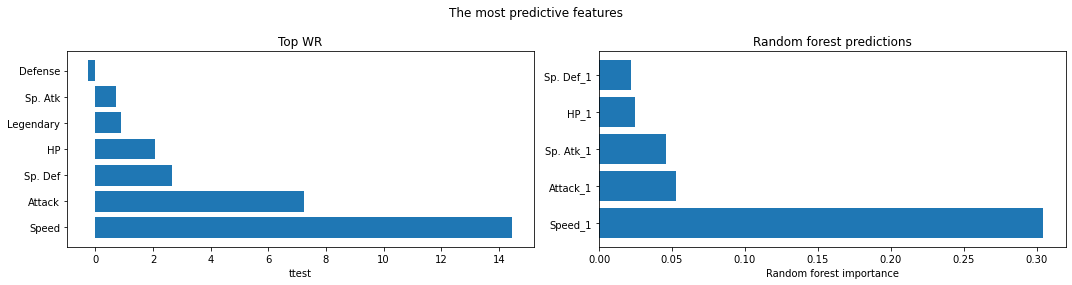

In [456]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

fig.suptitle('The most predictive features')

numerical_columns=top_WR.columns[3:10]
ttest_statistics=[ttest_ind(top_WR[column],df_pokemons[column],equal_var=False).statistic
                  for column in numerical_columns]

ax[0].barh([x for y, x in sorted(zip(ttest_statistics, numerical_columns))[::-1]], sorted(ttest_statistics)[::-1])
ax[0].set_xlabel('ttest')
ax[0].set_title('Top WR')

ax[1].barh(top_features.index[::2], top_features.values[::2])
ax[1].set_xlabel('Random forest importance')
ax[1].set_title('Random forest predictions')

plt.tight_layout()
plt.show()

Top 2 results are the same: Speed and Attack, the other results are somehow different. Probably extracting data from only top ten pokemons is not very representative 

# Dominance Graph

In [468]:
G=pd.DataFrame(data=np.zeros((len(df_pokemons.index),len(df_pokemons.index))),
               index=df_pokemons.index,columns=df_pokemons.index).astype(int)

In [475]:
for index,combat in tqdm(df_combats.iterrows()):
    
    first_poc_index=combat.First_pokemon
    second_poc_index=combat.Second_pokemon
    
    #1 for second and 0 for first
    result=int(combat.Winner==second_poc_index)
    
    #If second one we take as winner iloc[:,1] which is Second
    #If second lost we take as winner iloc[:,0] which is First
    winner=df_combats.iloc[index,result]
    loser=df_combats.iloc[index,int(np.logical_not(result))]
    
    #row of pokemon 'A' represents number of his victories
    G.loc[winner,loser]+=1
    
    #column of pokemon 'A' represents number of his losses
    G.loc[loser,winner]-=1

50000it [00:49, 1002.84it/s]


In [485]:
#Now replace zeros with NAN as dominances we may not define
#After that replace negative values with 0 and positive with 1
G.replace(0,np.nan,inplace=True)
G.replace(np.arange(1,G.max().max()+1),1,inplace=True)
G.replace(np.arange(G.min().min(),0),0,inplace=True)

In [486]:
G

pid,1,2,3,4,5,6,7,8,9,10,...,791,792,793,794,795,796,797,798,799,800
pid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0
2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,NaN
5,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
797,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [513]:
#Two many edges for graph
'''import networkx as nx

# we can create the directed graph
Graph=nx.DiGraph()

rows,columns=np.where(G==1)
for i in tqdm(rows):
    for j in columns:
        Graph.add_edge(i,j)'''

  0%|          | 97/44553 [00:11<1:24:28,  8.77it/s]


KeyboardInterrupt: 

In [564]:
A=pd.DataFrame(data=G.to_numpy()+np.power(G.to_numpy(),2),
               index=df_pokemons.index,columns=df_pokemons.index)

The square of an adjacency matrix A2=(sij) has the property that sij represents the number of walks of length two from vertex i to vertex j, hence we increase the number for those who had more opponents? like increasing in statistical meaning when we should normalize it?  

Otherwise G+G^2 can be a way of representation of the shortest path length from i to j https://aip.scitation.org/doi/pdf/10.1063/1.5062787

In [565]:
Winning_scores=pd.DataFrame(data=A.sum(axis=1),columns=['Dominance'])
Winning_scores['Name']=df_pokemons.Name
Winning_scores=Winning_scores.sort_values('Dominance',ascending=False).head(10)

In [566]:
print('Win rate metric top:',top_WR.Name.values)

Win rate metric top: ['Mega Aerodactyl' 'Weavile' 'Tornadus Therian Forme' 'Mega Beedrill'
 'Aerodactyl' 'Mega Lopunny' 'Greninja' 'Meloetta Pirouette Forme'
 'Mega Mewtwo Y' 'Mega Sharpedo']


In [567]:
top_WR[['Name','WR']]

,Name,WR
pid,,
155,Mega Aerodactyl,0.984496
513,Weavile,0.974790
704,Tornadus Therian Forme,0.968000
20,Mega Beedrill,0.966387
154,Aerodactyl,0.964539
477,Mega Lopunny,0.961240
727,Greninja,0.960630
717,Meloetta Pirouette Forme,0.959350
165,Mega Mewtwo Y,0.952000


In [568]:
Winning_scores[['Name','Dominance']]

,Name,Dominance
pid,,
344,Illumise,168.0
71,Alakazam,162.0
107,Krabby,156.0
163,Mewtwo,154.0
764,Clawitzer,152.0
657,Joltik,152.0
470,Shellos,152.0
374,Corphish,152.0
333,Aggron,152.0


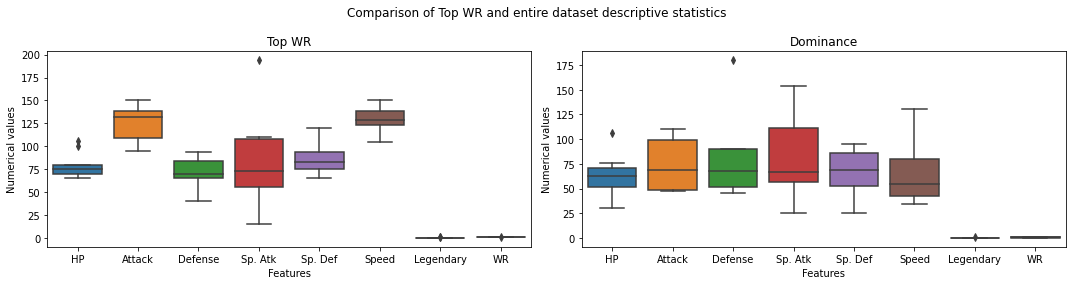

In [569]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

fig.suptitle('Comparison of Top WR and entire dataset descriptive statistics')

sns.boxplot(ax=ax[0],data=top_WR)
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Numerical values')
ax[0].set_title('Top WR')

sns.boxplot(ax=ax[1],data=df_pokemons.merge(Winning_scores,on='Name').drop('Dominance',axis=1))
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Numerical values')
ax[1].set_title('Dominance')

plt.tight_layout()
plt.show()

The problem is that in case of Win rate we account only for number of victories, but normalize on the number of all combats. For the Dominance we account both victories and losses, but do not normalize on number of opponents, hence some pokemons may have not very descriptive results. If we would normalize, we would get better metric

It dependce on what do we want: keep high WR or dominate everybody?

if we get new pokemon he would be weak in the begining, and then it may eventually rise to the top. Due to losses in the begining his WR may be bad, even if he is the strongest one, which is set by the dominance

Moreover a pokemon can win one combat and do not participate in combats any more, staying in the top with WR=1. Hence I consider WR metrics to be not very representative in the big distance.

However it is representative in terms of considering the most important features